In [10]:
import pandas as pd 
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [25]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# We want to check the correlation between the features and survival rate

corr = train_df.corr()
corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


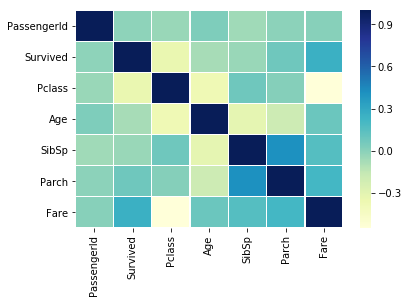

In [23]:
# create the heatmap to visualize correlations 
sns.heatmap(corr, linewidths = .5, cmap="YlGnBu")

# we can see that Pclass, Fare are two that are highly correlated with survival 
# next would be Parch, Age, SibSp, and finally PassengerId 

In [ ]:
# Since Age is an important factor, we want to fill in all of the missing ages with the average 

In [31]:
avg_age = train_df['Age'].mean()
med_age = train_df['Age'].median()
print(avg_age)
print(med_age)

train_df['Age'train_df['Age'].fillna(avg_age)

29.69911764705882
28.0


0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
5      29.699118
6      54.000000
7       2.000000
8      27.000000
9      14.000000
10      4.000000
11     58.000000
12     20.000000
13     39.000000
14     14.000000
15     55.000000
16      2.000000
17     29.699118
18     31.000000
19     29.699118
20     35.000000
21     34.000000
22     15.000000
23     28.000000
24      8.000000
25     38.000000
26     29.699118
27     19.000000
28     29.699118
29     29.699118
         ...    
861    21.000000
862    48.000000
863    29.699118
864    24.000000
865    42.000000
866    27.000000
867    31.000000
868    29.699118
869     4.000000
870    26.000000
871    47.000000
872    33.000000
873    47.000000
874    28.000000
875    15.000000
876    20.000000
877    19.000000
878    29.699118
879    56.000000
880    25.000000
881    33.000000
882    22.000000
883    28.000000
884    25.000000
885    39.000000
886    27.000000
887    19.000000
888    29.6991

In [32]:
train_df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
